# UCI Online Retail II dataset - Cohort Analysis

## Dataset Context
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

<br>

## Dataset Content
Attribute Information:

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

<br>

#### Reference
https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

**Question want to ask with cohort analysis**
- How the customers behavior changes over time and the pattern of behavior look like


In [1]:
# import library
import pandas as pd
import numpy as np
import datetime as dt

# Data Viusalization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(".\cleaned_data\customergroup_details.csv")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalAmount,Recency,Frequency,MonetaryValue,R,F,M,RFMSegment,RFMScore,CustomerGroup
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.4,158,84,2433.28,2,2,1,221,5,Bronze
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0,158,84,2433.28,2,2,1,221,5,Bronze
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0,158,84,2433.28,2,2,1,221,5,Bronze
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,100.8,158,84,2433.28,2,2,1,221,5,Bronze
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,30.0,158,84,2433.28,2,2,1,221,5,Bronze


**General Work Flow**
1. Preparation - Get the InvoiceDate and extract month and date from it
3. Define Base Date - Get the first purchase date of customers
4. Define Logging Period - Calculate differnece between every transaction with first purchase date in term of months
5. Presentation - Generate cohort analysis dataframe

### Data-preparation

In [4]:
# mondify datatypes
df['InvoiceDate'] = df['InvoiceDate'].astype(np.str).str.slice(0,10) 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
# function to get month and month + date
def get_month(date):
      """
      enter the date data, return the data with date modified as first day of the month
      """
      return dt.datetime(date.year,date.month,1)

def get_date(df, column):
      """
      enter the dataframe and column, return the month and date in int. format
      """
      year = df[column].dt.year
      month = df[column].dt.month
      return year, month


In [8]:
# First Billing Month
df["BillMonth"] = df["InvoiceDate"].apply(get_month)

In [9]:
# First Purchase Date
group = df.groupby("CustomerID")["BillMonth"]
df["CohortMonth"] = group.transform("min")


In [10]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalAmount,Recency,Frequency,MonetaryValue,R,F,M,RFMSegment,RFMScore,CustomerGroup,BillMonth,CohortMonth
779420,581578,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09,1.25,12713.0,Germany,15.00,1,38,848.55,4,3,3,433,10,Gold,2011-12-01,2011-12-01
779421,581578,22907,PACK OF 20 NAPKINS PANTRY DESIGN,12,2011-12-09,0.85,12713.0,Germany,10.20,1,38,848.55,4,3,3,433,10,Gold,2011-12-01,2011-12-01
779422,581578,22908,PACK OF 20 NAPKINS RED APPLES,12,2011-12-09,0.85,12713.0,Germany,10.20,1,38,848.55,4,3,3,433,10,Gold,2011-12-01,2011-12-01
779423,581578,23215,JINGLE BELL HEART ANTIQUE SILVER,12,2011-12-09,2.08,12713.0,Germany,24.96,1,38,848.55,4,3,3,433,10,Gold,2011-12-01,2011-12-01
779424,581578,22736,RIBBON REEL MAKING SNOWMEN,10,2011-12-09,1.65,12713.0,Germany,16.50,1,38,848.55,4,3,3,433,10,Gold,2011-12-01,2011-12-01


In [11]:
# Calculate the difference
BillYear, BillMonth = get_date(df, "BillMonth")
CohortYear, CohortMonth = get_date(df, "CohortMonth")

DiffYear = BillYear - CohortYear
DiffMonth = BillMonth - CohortMonth

df["Month_Index"] = DiffYear * 12 + DiffMonth + 1

### Retention by Monthly Cohorts

In [12]:
group = df.groupby(["CohortMonth", "Month_Index"])
cohort_data = group["CustomerID"].apply(pd.Series.nunique).reset_index() #count the unique customerID

# cohort_data.head()

In [13]:
cohort_data.head()

,CohortMonth,Month_Index,CustomerID
0,2009-12-01,1,955
1,2009-12-01,2,337
2,2009-12-01,3,319
3,2009-12-01,4,406
4,2009-12-01,5,363


In [14]:
# turn into pivot table
cohort_counts = cohort_data.pivot(index = "CohortMonth", columns = "Month_Index", values= "CustomerID")
cohort_counts

Month_Index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,...,289.0,251.0,289.0,270.0,248.0,244.0,301.0,291.0,389.0,188.0
2010-01-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,...,58.0,90.0,76.0,71.0,75.0,93.0,74.0,94.0,22.0,NaN
2010-02-01,374.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,...,75.0,60.0,61.0,54.0,86.0,86.0,61.0,22.0,NaN,NaN
2010-03-01,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,48.0,...,75.0,77.0,69.0,78.0,89.0,94.0,35.0,NaN,NaN,NaN
2010-04-01,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,31.0,32.0,...,46.0,41.0,44.0,53.0,66.0,17.0,NaN,NaN,NaN,NaN
2010-05-01,254.0,40.0,43.0,44.0,45.0,65.0,54.0,32.0,15.0,21.0,...,32.0,35.0,42.0,39.0,12.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,270.0,47.0,51.0,55.0,62.0,77.0,34.0,24.0,22.0,32.0,...,33.0,36.0,55.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,186.0,29.0,34.0,55.0,54.0,26.0,21.0,27.0,27.0,21.0,...,32.0,44.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,162.0,33.0,48.0,52.0,28.0,19.0,16.0,20.0,22.0,21.0,...,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Set the first column as base = 100
cohort_sizes = cohort_counts.iloc[:, 0]

retention = cohort_counts.divide(cohort_sizes, axis = 0) * 100 #apply divide function to turn data into pct.
retention.round(2)

Month_Index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,100.0,35.29,33.40,42.51,38.01,35.92,37.70,34.24,33.61,36.23,...,30.26,26.28,30.26,28.27,25.97,25.55,31.52,30.47,40.73,19.69
2010-01-01,100.0,20.63,31.07,30.55,26.37,30.03,25.85,22.98,27.94,31.85,...,15.14,23.50,19.84,18.54,19.58,24.28,19.32,24.54,5.74,NaN
2010-02-01,100.0,23.80,22.46,29.14,24.60,20.05,19.25,28.61,25.40,27.54,...,20.05,16.04,16.31,14.44,22.99,22.99,16.31,5.88,NaN,NaN
2010-03-01,100.0,18.96,23.02,24.15,23.25,20.32,24.60,30.25,27.54,10.84,...,16.93,17.38,15.58,17.61,20.09,21.22,7.90,NaN,NaN,NaN
2010-04-01,100.0,19.39,19.39,16.33,18.37,22.45,27.55,26.19,10.54,10.88,...,15.65,13.95,14.97,18.03,22.45,5.78,NaN,NaN,NaN,NaN
2010-05-01,100.0,15.75,16.93,17.32,17.72,25.59,21.26,12.60,5.91,8.27,...,12.60,13.78,16.54,15.35,4.72,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,17.41,18.89,20.37,22.96,28.52,12.59,8.89,8.15,11.85,...,12.22,13.33,20.37,5.19,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,15.59,18.28,29.57,29.03,13.98,11.29,14.52,14.52,11.29,...,17.20,23.66,8.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,20.37,29.63,32.10,17.28,11.73,9.88,12.35,13.58,12.96,...,19.75,6.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
month_list = ["Dec 2009", 
            "Jan 2010", "Feb 2010", "Mar 2010", "Apr 2010", "May 2010", "Jun 2010", "Jul 2010", "Aug 2010", "Sep 2010", "Oct 2010", "Nov 2010", "Dec 2010", 
            "Jan 2011", "Feb 2011", "Mar 2011", "Apr 2011", "May 2011", "Jun 2011", "Jul 2011", "Aug 2011", "Sep 2011", "Oct 2011", "Nov 2011", "Dec 2011"]


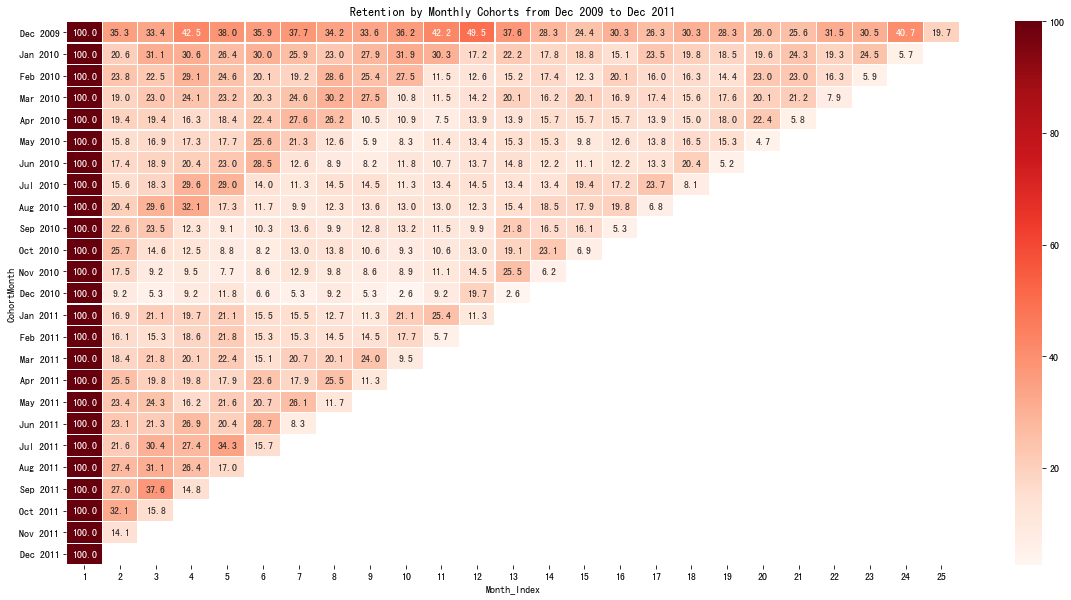

In [25]:
plt.figure(figsize = (20,10))
sns.heatmap(data = retention.round(2), annot = True, cmap = "Reds", fmt = ".1f", linewidths = 0.2, yticklabels = month_list)
plt.title("Retention by Monthly Cohorts from Dec 2009 to Dec 2011")

# plt.savefig('Retention_Cohorts.jpeg',
#             bbox_inches='tight',
#             pad_inches=0.1,
#             format='jpeg',
            # dpi=300)


### Finding

***Special group***
- Group of 2009 Dec, have a high retention rate, keep remaining around 20 - 40 % 
- Group of 2010 Dec, have a relatively low retention rate that keeping under 12 % afterward


***Special period***
- All groups have a significant increase in retention rate in Oct, Nov 2010, and Nov 2011, we believe it is related to the Black Friday events.


***Special trend***
- A notable increase in the retention of the group after Jan 2011 can be observed from the cohort analysis.

### Average quantity by Monthly Cohorts (optional)

In [ ]:
# group = df.groupby(["CohortMonth", "Month_Index"])
# cohort_data = group["Quantity"].mean().reset_index()

# average_quantity = cohort_data.pivot(index = "CohortMonth", columns = "Month_Index", values= "Quantity")
# average_quantity.round(1)

# # cohort_data.head()

In [ ]:
# plt.figure(figsize = (20,10))
# sns.heatmap(data = average_quantity.round(1), annot = True, cmap = "Reds", fmt = ".1f", linewidths = 0.2, yticklabels = month_list)
# plt.title("Average quantity by Monthly Cohorts from Dec 2009 to Dec 2011")